In [1]:
import pandas as pd
import numpy as np
import mne
import matplotlib

In [2]:
metadata = pd.read_csv('../data/train.csv')
metadata.set_index('eeg_id', inplace=True)
# list unique eeg_ids
eeg_ids = metadata.index.unique()

In [3]:
parquet_file_path = f'../data/train_eegs/{eeg_ids[0]}.parquet'
df = pd.read_parquet(parquet_file_path)
data = df.to_numpy().T
channel_names = df.columns.tolist()
channel_types = ['eeg'] * 19 + ['ecg']
info = mne.create_info(ch_names=channel_names, sfreq=200, ch_types=channel_types)
raw = mne.io.RawArray(data, info)
# raw.save(f'../data/train_mne/{eeg_ids[0]}.fif', overwrite=True)

Creating RawArray with float64 data, n_channels=20, n_times=18000
    Range : 0 ... 17999 =      0.000 ...    89.995 secs
Ready.


In [4]:
raw.plot(duration=50, n_channels=20, start=0, scalings = {'eeg': 100.0, 'ecg': 400.0} )

Using qt as 2D backend.


QStandardPaths: wrong permissions on runtime directory /run/user/1000/, 0755 instead of 0700


Identify bad channels

Correlations based on spatial locations

Set up a 10-20 montage

In [5]:
# Load a standard montage from MNE-Python
montage = mne.channels.make_standard_montage('standard_1020')

# Apply the montage to the Raw object
raw.set_montage(montage)


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,"19 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,EKG
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


In [6]:
# Get the 3D coordinates of the electrodes
pos = np.array([raw.info['chs'][i]['loc'][:3] for i in range(raw.info['nchan'])])

# Calculate distances between all pairs of electrodes
from scipy.spatial.distance import pdist, squareform
distances = squareform(pdist(pos))

# Define neighbors: electrodes within a certain distance (e.g., top 25% closest electrodes)
neighbor_threshold = np.percentile(distances[distances > 0], 25)  # Exclude zero distance (self)
neighbors = distances <= neighbor_threshold

In [7]:
# Compute correlation matrix of the EEG data
correlation_matrix = np.corrcoef(raw.get_data())

# For each channel, compute the mean correlation with its neighbors
mean_correlation_with_neighbors = np.array([correlation_matrix[i, neighbors[i]].mean() for i in range(len(pos))])

# Threshold to identify bad channels based on correlation
correlation_threshold = 0.4  # This is arbitrary and should be adjusted based on your data

# Identify bad channels
bad_channels_correlation = [raw.ch_names[i] for i, mean_corr in enumerate(mean_correlation_with_neighbors) if mean_corr < correlation_threshold]

bad_channels_correlation


['O1', 'Fz', 'Pz']

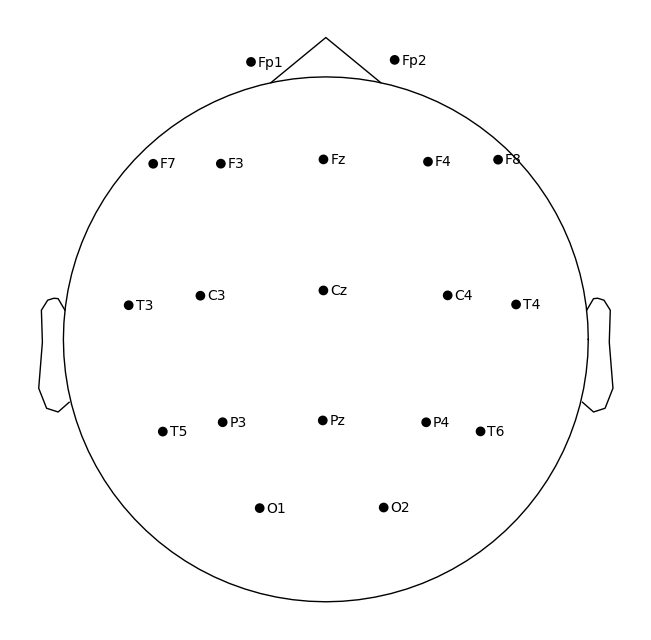

IndexError: list index out of range

The X11 connection broke (error 1). Did the X11 server die?


: 

In [8]:
# plot the locations of the standard 10-20 system
fig = mne.viz.plot_sensors(raw.info, show_names=True)
# colour bad channels red
fig.gca().set_title('Bad channels in red')
for bad_channel in bad_channels_correlation:
    idx = raw.ch_names.index(bad_channel)
    fig.gca().lines[idx].set_color('red')
fig.show()